# **📄 Document type classification baseline code**
## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [ ]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
!tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [ ]:
# 필요한 라이브러리를 설치합니다.
!pip install timm

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [1]:
import os
import time
import random

import timm
import torch
import augraphy as ag
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from PIL import ImageOps
import re 
from PIL import ImageEnhance, ImageFilter
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import pytesseract
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# 데이터셋 클래스를 정의합니다.
#oversampling -> 클래스 빈 130개 채워서 1700개 : max_oversample 로 배율 조정
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None, oversample=False, max_oversample=4, use_ocr=False):
        self.df = pd.read_csv(csv)
        self.path = path
        self.transform = transform
        self.oversample = oversample
        self.max_oversample = max_oversample
        self.use_ocr = use_ocr

        # OCR 대상 클래스 텍스트 추출 및 벡터화
        if self.use_ocr:
            ocr_texts = [
                extract_text_from_image(os.path.join(self.path, row['ID'])) 
                if row['target'] in [3, 4, 7, 14] else "" 
                for _, row in self.df.iterrows()
            ]
            self.text_vectors = text_to_vector(ocr_texts)
        else:
            self.text_vectors = [np.zeros(50) for _ in range(len(self.df))]  # OCR 비활성화 시 기본 0 벡터 사용
            
        if self.oversample:
            self.df, self.text_vectors = self.apply_oversampling(self.df, self.text_vectors)

    def apply_oversampling(self, df, text_vectors):
        class_counts = Counter(df['target'])
        max_count = int(max(class_counts.values()) * self.max_oversample)  # 설정한 배수만큼 샘플 수 제한
        oversampled_df = df.copy()
        oversampled_text_vectors = text_vectors[:]

        for cls, count in class_counts.items():
            if count < max_count:
                # 부족한 샘플 수만큼 추가 복제
                samples_to_add = df[df['target'] == cls]
                text_vectors_to_add = [text_vectors[i] for i in samples_to_add.index]
                
                for _ in range(max_count // count - 1):  # 배수만큼 추가
                    oversampled_df = pd.concat([oversampled_df, samples_to_add])
                    oversampled_text_vectors.extend(text_vectors_to_add)
                
                # 나머지 추가 복제
                remainder = max_count % count
                if remainder > 0:
                    oversampled_df = pd.concat([oversampled_df, samples_to_add.sample(remainder, replace=True)])
                    oversampled_text_vectors.extend(text_vectors_to_add[:remainder])

        return oversampled_df.sample(frac=1).reset_index(drop=True), oversampled_text_vectors

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        image_name = self.df.iloc[idx]['ID']
        target = self.df.iloc[idx]['target']
        img_path = os.path.join(self.path, image_name)
        img = np.array(Image.open(img_path).convert("RGB"))
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        # OCR 텍스트 벡터 가져오기
        text_vector = self.text_vectors[idx] if self.use_ocr and target in [3, 4, 7, 14] else np.zeros(50)
        
        return img, torch.tensor(text_vector, dtype=torch.float32), target

In [4]:
def preprocess_image_for_ocr(img):
    # 이미지 확대
    img = img.resize((img.width * 2, img.height * 2), Image.LANCZOS)
    
    # 밝기 및 대비 조절
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2)  # 대비 증가
    enhancer = ImageEnhance.Brightness(img)
    img = enhancer.enhance(1.5)  # 밝기 증가
    
    # 이미지 날카로움 증가
    img = img.filter(ImageFilter.SHARPEN)
    
    # Augraphy 변형 설정 및 적용
    pipeline = ag.Compose([
        ag.DirtyRollers(p=0.5),    # 먼지 효과 추가
        ag.NoiseTexturize(p=0.5),  # 노이즈 텍스처화
        ag.Brighten(p=0.3, factor=(1.25, 1.5)),  # 밝기 증가
        ag.FoldingEffect(p=0.5, fold_height=(5, 20), fold_width=(5, 15), gradient_width=(0.1, 0.3)),
        ag.InkBleed(p=0.3, intensity_range=(0.1, 0.2)),
        ag.InkMottling(p=0.3, severity=(0.2, 0.4)),
        ag.SubtleNoiseTexturize(p=0.4, sigma=(0.1, 0.3)),
        ag.GaussianBlur(p=0.3, sigma=(0.1, 1.5)),
        ag.LowInkLine(p=0.4, count_range=(2, 5), use_consistent_lines=False),
        ag.Jitter(p=0.3, sigma=(1, 2)),
        ag.LightingGradient(p=0.5, transparency=(0.75, 0.85), direction=0.5),
        ag.Watermark(p=0.3, text="CONFIDENTIAL", font_size_range=(20, 40), rotation_range=(0, 90))
    ])
    
    # Augraphy로 변형 적용
    img = pipeline(img)

    # 노이즈 제거 및 이진화 처리
    img = img.convert('L')  # 그레이스케일로 변환
    threshold = 140  # 이진화 임계값 설정
    img = img.point(lambda p: p > threshold and 255)  # 이진화 적용

    return img

def extract_text_from_image(image_path):
    # 이미지 열기 및 전처리
    img = Image.open(image_path).convert("RGB")
    img = preprocess_image_for_ocr(img)  
    # OCR로 텍스트 추출 (한국어+영어)
    text = pytesseract.image_to_string(img, lang='kor', config='--psm 6')
    # 특수 문자 제거 (필요에 따라 조정)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  
    return text.strip()

# 텍스트 벡터화 (TF-IDF + 차원 축소)
def text_to_vector(texts):
    vectorizer = TfidfVectorizer(max_features=500)
    text_vectors = vectorizer.fit_transform(texts)
    svd = TruncatedSVD(n_components=50)  # 차원 축소
    text_vectors = svd.fit_transform(text_vectors)
    return text_vectors

In [5]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, weight=None):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha  # Focal Loss 
        self.gamma = gamma  # Focal Loss의 
        self.weight = weight  # Cross-Entropy 

    def forward(self, outputs, targets):
        # Cross-Entropy 
        cross_entropy_loss = F.cross_entropy(outputs, targets, weight=self.weight)

        # Focal Loss 
        ce_loss = F.cross_entropy(outputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # 예측 확률
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()

        total_loss = self.alpha * focal_loss + (1 - self.alpha) * cross_entropy_loss
        return total_loss


In [6]:
#Mixed Precision Training

scaler = GradScaler()  # Mixed Precision Training을 위한 스케일러 초기화

def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, text, targets in pbar:
        image, text, targets = image.to(device), text.to(device), targets.to(device)

        optimizer.zero_grad(set_to_none=True)
        with autocast():  # Mixed Precision 적용
            preds = model(image, text)
            loss = loss_fn(preds, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret


EDA

클래스별 샘플 수:
 target
16    100
10    100
0     100
3     100
12    100
8     100
2     100
11    100
7     100
9     100
15    100
5     100
4     100
6     100
13     74
14     50
1      46
Name: count, dtype: int64
클래스별 비율:
 target
16    0.063694
10    0.063694
0     0.063694
3     0.063694
12    0.063694
8     0.063694
2     0.063694
11    0.063694
7     0.063694
9     0.063694
15    0.063694
5     0.063694
4     0.063694
6     0.063694
13    0.047134
14    0.031847
1     0.029299
Name: count, dtype: float64


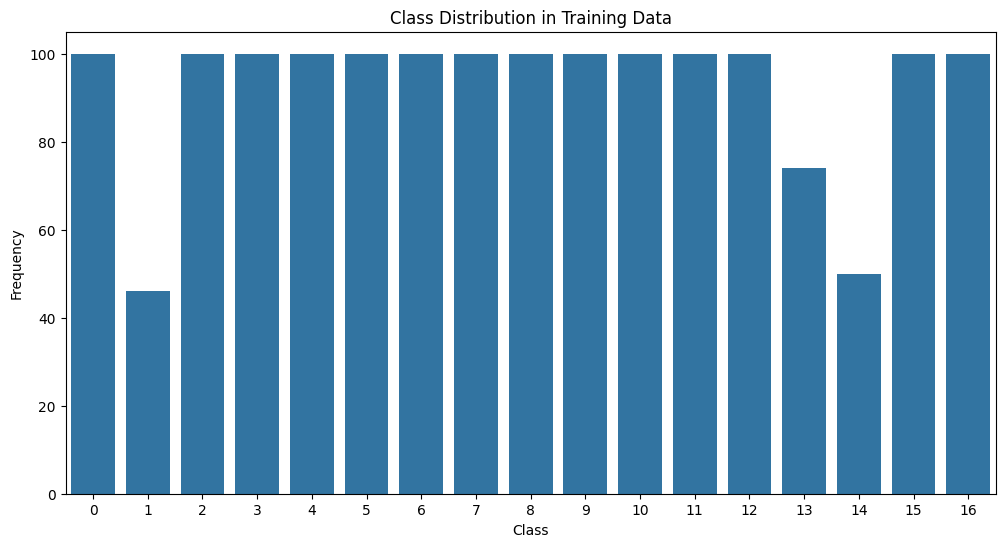

In [6]:
# 데이터 불러오기
data_sample = pd.read_csv("/root/data/train.csv")  # 훈련 데이터 파일

# 클래스 분포 확인
class_counts = data_sample['target'].value_counts()
print("클래스별 샘플 수:\n", class_counts)

# 비율 계산
total_count = len(data_sample)
class_ratios = class_counts / total_count
print("클래스별 비율:\n", class_ratios)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Data")
plt.show()

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '/root/data'

# model config
model_name = 'tf_efficientnetv2_m' # 'resnet50' 'efficientnet-b0', ...
model_name2 = 'convnext_small'

# training config
img_size = 288
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
num_workers = 2

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [98]:
from collections import defaultdict

# 클래스별 이미지 통계 계산 함수
def calculate_class_stats(df, img_dir):
    class_stats = defaultdict(list)
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = f"{img_dir}/{row['ID']}"  # 이미지 경로
        target = row['target']  # 클래스 레이블
        img = Image.open(img_path).convert("RGB")
        
        # tensor 
        img_array = np.array(transforms.ToTensor()(img).permute(1, 2, 0))
        
        # 각 채널별 평균과 표준편차 계산
        mean = img_array.mean(axis=(0, 1))
        std = img_array.std(axis=(0, 1))
        
        # 클래스별로 평균과 표준편차 저장
        class_stats[target].append((mean, std))
    
    # 각 클래스별 평균과 표준편차의 평균 계산
    class_mean_std = {
        cls: (np.mean([s[0] for s in stats], axis=0), np.mean([s[1] for s in stats], axis=0))
        for cls, stats in class_stats.items()
    }
    return class_mean_std

In [424]:
df = pd.read_csv("/root/data/train.csv")  # 훈련 데이터프레임 불러오기
img_dir = "/root/data/train"  # 이미지 디렉토리 경로
class_mean_std = calculate_class_stats(df, img_dir)

# 각 클래스의 평균과 표준편차 출력
for cls, (mean, std) in class_mean_std.items():
    print(f"클래스 {cls} - Mean: {mean}, Std: {std}")

100%|██████████| 1570/1570 [00:28<00:00, 55.24it/s]


클래스 16 - Mean: [0.4219013  0.4295417  0.42146945], Std: [0.2373147  0.23417273 0.23942035]
클래스 10 - Mean: [0.6575105  0.66326165 0.6644608 ], Std: [0.13163847 0.12877204 0.12457712]
클래스 4 - Mean: [0.6555603  0.66125077 0.66331756], Std: [0.15522847 0.15262605 0.14899264]
클래스 5 - Mean: [0.4437757  0.45977414 0.46266812], Std: [0.3156187  0.3196577  0.31643304]
클래스 15 - Mean: [0.6350243  0.64473253 0.6507628 ], Std: [0.1678749  0.16353387 0.15797006]
클래스 14 - Mean: [0.6480721  0.6549895  0.65739745], Std: [0.13476998 0.13317542 0.13080387]
클래스 9 - Mean: [0.5308454  0.5393029  0.54112315], Std: [0.3078833  0.30661288 0.3008869 ]
클래스 13 - Mean: [0.6464133 0.6576297 0.6628065], Std: [0.16119514 0.1606536  0.1597504 ]
클래스 7 - Mean: [0.63879293 0.6516734  0.6549295 ], Std: [0.14560634 0.14385152 0.14064762]
클래스 11 - Mean: [0.5965798  0.61167085 0.6179784 ], Std: [0.18097693 0.17057073 0.17047977]
클래스 2 - Mean: [0.29230753 0.26621136 0.2712087 ], Std: [0.19488445 0.18460369 0.18703903]
클래스 8 -

In [425]:
# 클래스별 평균(mean)과 표준편차(std) 값 저장
means = np.array([
    [0.4219013, 0.4295417, 0.42146945],
    [0.6575105, 0.66326165, 0.6644608],
    [0.6555603, 0.66125077, 0.66331756],
    [0.4437757, 0.45977414, 0.46266812],
    [0.6350243, 0.64473253, 0.6507628],
    [0.6480721, 0.6549895, 0.65739745],
    [0.5308454, 0.5393029, 0.54112315],
    [0.6464133, 0.6576297, 0.6628065],
    [0.63879293, 0.6516734, 0.6549295],
    [0.5965798, 0.61167085, 0.6179784],
    [0.29230753, 0.26621136, 0.2712087],
    [0.4591894, 0.48785004, 0.5136458],
    [0.6531739, 0.6636219, 0.66996545],
    [0.65375656, 0.6593415, 0.6593775],
    [0.5997213, 0.61057276, 0.6175231],
    [0.6672302, 0.6775926, 0.6834501],
    [0.6696616, 0.6832548, 0.69261336]
])

stds = np.array([
    [0.2373147, 0.23417273, 0.23942035],
    [0.13163847, 0.12877204, 0.12457712],
    [0.15522847, 0.15262605, 0.14899264],
    [0.3156187, 0.3196577, 0.31643304],
    [0.1678749, 0.16353387, 0.15797006],
    [0.13476998, 0.13317542, 0.13080387],
    [0.3078833, 0.30661288, 0.3008869],
    [0.16119514, 0.1606536, 0.1597504],
    [0.14560634, 0.14385152, 0.14064762],
    [0.18097693, 0.17057073, 0.17047977],
    [0.19488445, 0.18460369, 0.18703903],
    [0.2949226, 0.30572063, 0.31396866],
    [0.13231365, 0.12964574, 0.1266244],
    [0.14589216, 0.14422888, 0.14131746],
    [0.151559, 0.149929, 0.14750864],
    [0.14367767, 0.14226489, 0.13918385],
    [0.1630469, 0.150923, 0.14306074]
])

# 전체 평균(mean)과 표준편차(std)를 계산
overall_mean = means.mean(axis=0)
overall_std = stds.mean(axis=0)

overall_mean, overall_std

(array([0.58055977, 0.58954542, 0.59439398]),
 array([0.18614137, 0.18358485, 0.18168615]))

In [8]:
# 훈련 데이터에 대한 Transform 코드

trn_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.8, 1.2), ratio=(0.75, 1.33), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-40,40), p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.3),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, min_holes=1, fill_value=0, p=0.5),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.GaussianBlur(blur_limit=(3,7), p=0.2),
    A.GaussNoise(always_apply=False, var_limit=(50.0, 200.0), p=0.5, per_channel=True, mean= 0.0),
    A.Affine(shear=15, rotate=10, scale=(0.9, 1.1), p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.3),
    A.ImageCompression(quality_lower=70, quality_upper=100, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3), 
    
    # 추가 
    A.GridDropout(ratio=0.5, holes_number_x=3, holes_number_y=3, p=0.3),  # GridMask
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
    A.ChannelShuffle(p=0.1),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.2),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.2),  # 이미지 선명화 추가
    A.Normalize(mean=[0.5805, 0.5895, 0.5944], std=[0.186, 0.183, 0.187]),
    ToTensorV2(),
])

# 테스트 데이터에 대한 Transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.5805, 0.5895, 0.5944], std=[0.186, 0.183, 0.187]),
    ToTensorV2(),
])


In [9]:
# Dataset 정의
trn_dataset = ImageDataset(
    "/root/data/train.csv",
    "/root/data/train/",
    transform=trn_transform,
    oversample=True
)
tst_dataset = ImageDataset(
    "/root/data/sample_submission.csv",
    "/root/data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

6800 3140


In [10]:
# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=False,
    drop_last=False
)
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [46]:
print(timm.list_models("*efficientnet*"))

['efficientnet_b0', 'efficientnet_b0_g8_gn', 'efficientnet_b0_g16_evos', 'efficientnet_b0_gn', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b3', 'efficientnet_b3_g8_gn', 'efficientnet_b3_gn', 'efficientnet_b3_pruned', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_b8', 'efficientnet_cc_b0_4e', 'efficientnet_cc_b0_8e', 'efficientnet_cc_b1_8e', 'efficientnet_el', 'efficientnet_el_pruned', 'efficientnet_em', 'efficientnet_es', 'efficientnet_es_pruned', 'efficientnet_l2', 'efficientnet_lite0', 'efficientnet_lite1', 'efficientnet_lite2', 'efficientnet_lite3', 'efficientnet_lite4', 'efficientnetv2_l', 'efficientnetv2_m', 'efficientnetv2_rw_m', 'efficientnetv2_rw_s', 'efficientnetv2_rw_t', 'efficientnetv2_s', 'efficientnetv2_xl', 'gc_efficientnetv2_rw_t', 'tf_efficientnet_b0', 'tf_efficientnet_b1', 'tf_efficientnet_b2', 'tf_efficientnet_b3', 'tf_efficientnet_b4', 'tf_efficientnet_b5', 'tf_eff

In [11]:
class MultimodalModel(nn.Module):
    def __init__(self, model_name, text_dim=50, num_classes=17, text_weight=1.5):
        super(MultimodalModel, self).__init__()
        self.image_model = timm.create_model(model_name, pretrained=True, num_classes=0)  # 최종 분류 레이어 제거
        self.text_fc = nn.Linear(text_dim, 256)  # 텍스트 벡터를 위한 추가 레이어
        self.classifier = nn.Linear(256 + self.image_model.num_features, num_classes)  # 이미지와 텍스트 특징 결합
        self.text_weight = text_weight

    def forward(self, image, text):
        img_features = self.image_model(image)
        text_features = self.text_fc(text)
        
        # 이미지와 텍스트 특징을 결합하여 최종 분류 레이어에 전달
        combined_features = torch.cat([img_features, text_features], dim=1)
        return self.classifier(combined_features)


In [29]:
"""
class MultimodalModel2(nn.Module):
    def __init__(self, model_name2, text_dim=50, num_classes=17, text_weight=1.5):
        super(MultimodalModel2, self).__init__()
        self.image_model = timm.create_model(model_name2, pretrained=True, num_classes=0)  # 최종 분류 레이어 제거
        self.text_fc = nn.Linear(text_dim, 256)  # 텍스트 벡터를 위한 추가 레이어
        self.classifier = nn.Linear(256 + self.image_model.num_features, num_classes)  # 이미지와 텍스트 특징 결합
        self.text_weight = text_weight

    def forward(self, image, text):
        img_features = self.image_model(image)
        text_features = self.text_fc(text)
        
        # 이미지와 텍스트 특징을 결합하여 최종 분류 레이어에 전달
        combined_features = torch.cat([img_features, text_features], dim=1)
        return self.classifier(combined_features)
"""

In [11]:
""""
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

#loss_fn = FocalLoss(alpha=1, gamma=2)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
"""

In [30]:
class_weights = torch.tensor([1.0] * 17).to(device) 
class_weights[[3, 4, 7, 14]] *= 2 

model = MultimodalModel(
    model_name=model_name,
    text_dim=50,  # 텍스트 벡터의 차원
    num_classes=17
).to(device)

#loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights)
loss_fn = CombinedLoss(alpha=0.5, gamma=2.0, weight=class_weights).to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [31]:
"""
class_weights = torch.tensor([1.0] * 17).to(device) 
class_weights[[3, 4, 7, 14]] *= 2 

model2 = MultimodalModel(
    model_name=model_name2,
    text_dim=50,  # 텍스트 벡터의 차원
    num_classes=17
).to(device)

#loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1,weight=class_weights)
loss_fn = CombinedLoss(alpha=0.5, gamma=2.0, weight=class_weights).to(device)
optimizer = AdamW(model2.parameters(), lr=LR, weight_decay=1e-4)
"""

In [13]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

# 조기 종료 설정
patience = 5  # 개선되지 않는 에포크 수
best_f1 = 0   # 최고 F1 스코어
early_stopping_counter = 0  # 조기 종료 카운터

# 학습률 스케줄러 설정
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
#scheduler = OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(trn_loader), epochs=EPOCHS)

# 학습 루프
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    text_weight = 1.5  # 특정 클래스에서 텍스트 비중을 높이는 값

    for images, text_vectors, targets in trn_loader:
        images, text_vectors, targets = images.to(device), text_vectors.to(device), targets.to(device)
        
        optimizer.zero_grad()

        # 특정 클래스의 경우 텍스트 비중을 높임
        mask = torch.isin(targets, torch.tensor([3, 4, 7, 14], device=device))
        text_vectors = torch.where(mask.unsqueeze(1), text_vectors * text_weight, text_vectors)

        # 모델에 이미지와 텍스트 벡터를 전달
        outputs = model(images, text_vectors)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(outputs.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

    train_loss /= len(trn_loader)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # Scheduler step을 F1 스코어 기준으로 조정
    scheduler.step(train_f1)

    # F1 스코어 개선 확인
    if train_f1 > best_f1:
        best_f1 = train_f1  # 최고 F1 갱신
        early_stopping_counter = 0  # 카운터 초기화
    else:
        early_stopping_counter += 1  # 개선되지 않으면 카운터 증가

    # 조기 종료 조건 확인
    if early_stopping_counter >= patience:
        print("Early stopping due to no improvement in F1 score.")
        break  # 학습 중단

    # 로그 출력
    log = f"Epoch {epoch + 1}\nTrain Loss: {train_loss:.4f}\nTrain F1 Score: {train_f1:.4f}\n"
    print(log)


Epoch 1
Train Loss: 0.9963
Train F1 Score: 0.6705

Epoch 2
Train Loss: 0.3231
Train F1 Score: 0.8830

Epoch 3
Train Loss: 0.2142
Train F1 Score: 0.9161

Epoch 4
Train Loss: 0.1669
Train F1 Score: 0.9380

Epoch 5
Train Loss: 0.1407
Train F1 Score: 0.9459

Epoch 6
Train Loss: 0.1242
Train F1 Score: 0.9527

Epoch 7
Train Loss: 0.1002
Train F1 Score: 0.9647

Epoch 8
Train Loss: 0.0956
Train F1 Score: 0.9653

Epoch 9
Train Loss: 0.0836
Train F1 Score: 0.9690

Epoch 10
Train Loss: 0.0772
Train F1 Score: 0.9731

Epoch 11
Train Loss: 0.0757
Train F1 Score: 0.9728

Epoch 12
Train Loss: 0.0616
Train F1 Score: 0.9777

Epoch 13
Train Loss: 0.0679
Train F1 Score: 0.9755

Epoch 14
Train Loss: 0.0599
Train F1 Score: 0.9796

Epoch 15
Train Loss: 0.0512
Train F1 Score: 0.9813

Epoch 16
Train Loss: 0.0497
Train F1 Score: 0.9825

Epoch 17
Train Loss: 0.0509
Train F1 Score: 0.9820

Epoch 18
Train Loss: 0.0475
Train F1 Score: 0.9830

Epoch 19
Train Loss: 0.0463
Train F1 Score: 0.9824

Epoch 20
Train Loss: 

In [32]:
"""
# 조기 종료 설정
patience = 5  # 개선되지 않는 에포크 수
best_f1 = 0   # 최고 F1 스코어
early_stopping_counter = 0  # 조기 종료 카운터

# 학습률 스케줄러 설정
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
#scheduler = OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(trn_loader), epochs=EPOCHS)

# 학습 루프
for epoch in range(EPOCHS):
    model2.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    text_weight = 1.5  # 특정 클래스에서 텍스트 비중을 높이는 값

    for images, text_vectors, targets in trn_loader:
        images, text_vectors, targets = images.to(device), text_vectors.to(device), targets.to(device)
        
        optimizer.zero_grad()

        # 특정 클래스의 경우 텍스트 비중을 높임
        mask = torch.isin(targets, torch.tensor([3, 4, 7, 14], device=device))
        text_vectors = torch.where(mask.unsqueeze(1), text_vectors * text_weight, text_vectors)

        # 모델에 이미지와 텍스트 벡터를 전달
        outputs = model2(images, text_vectors)
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(outputs.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

    train_loss /= len(trn_loader)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    # Scheduler step을 F1 스코어 기준으로 조정
    scheduler.step(train_f1)

    # F1 스코어 개선 확인
    if train_f1 > best_f1:
        best_f1 = train_f1  # 최고 F1 갱신
        early_stopping_counter = 0  # 카운터 초기화
    else:
        early_stopping_counter += 1  # 개선되지 않으면 카운터 증가

    # 조기 종료 조건 확인
    if early_stopping_counter >= patience:
        print("Early stopping due to no improvement in F1 score.")
        break  # 학습 중단

    # 로그 출력
    log = f"Epoch {epoch + 1}\nTrain Loss: {train_loss:.4f}\nTrain F1 Score: {train_f1:.4f}\n"
    print(log)
"""

Epoch 1
Train Loss: 0.9385
Train F1 Score: 0.6477

Epoch 2
Train Loss: 0.3658
Train F1 Score: 0.8581

Epoch 3
Train Loss: 0.2726
Train F1 Score: 0.8919

Epoch 4
Train Loss: 0.2088
Train F1 Score: 0.9149

Epoch 5
Train Loss: 0.1830
Train F1 Score: 0.9271

Epoch 6
Train Loss: 0.1642
Train F1 Score: 0.9368

Epoch 7
Train Loss: 0.1547
Train F1 Score: 0.9386

Epoch 8
Train Loss: 0.1537
Train F1 Score: 0.9432

Epoch 9
Train Loss: 0.1369
Train F1 Score: 0.9476

Epoch 10
Train Loss: 0.1174
Train F1 Score: 0.9558

Epoch 11
Train Loss: 0.1184
Train F1 Score: 0.9549

Epoch 12
Train Loss: 0.0969
Train F1 Score: 0.9612

Epoch 13
Train Loss: 0.0973
Train F1 Score: 0.9651

Epoch 14
Train Loss: 0.0895
Train F1 Score: 0.9665

Epoch 15
Train Loss: 0.0892
Train F1 Score: 0.9663

Epoch 16
Train Loss: 0.0960
Train F1 Score: 0.9626

Epoch 17
Train Loss: 0.0774
Train F1 Score: 0.9710

Epoch 18
Train Loss: 0.0824
Train F1 Score: 0.9695

Epoch 19
Train Loss: 0.0727
Train F1 Score: 0.9734

Epoch 20
Train Loss: 

In [17]:
"""
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

# Prediction 저장소 초기화
fold_predictions = []

# K-Fold 설정
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(trn_dataset.df, trn_dataset.df['target'])):
    print(f"Training fold {fold + 1}/{n_splits}")

    # Train/Validation Subset 생성
    train_subset = Subset(trn_dataset, train_idx)
    val_subset = Subset(trn_dataset, val_idx)
    
    # DataLoader 정의
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True, persistent_workers=False, drop_last=False)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=False)

    # 모델 초기화
    model = MultimodalModel(
        model_name=model_name,
        text_dim=50,  # 텍스트 벡터의 차원
        num_classes=17
    ).to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    # 학습 루프
    patience = 3
    early_stopping_counter = 0
    fold_best_f1 = 0
    text_weight = 1.5  # 특정 클래스에서 텍스트 비중을 높이는 값
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        preds_list = []
        targets_list = []
        
        for images, text_vectors, targets in train_loader:
            images, text_vectors, targets = images.to(device), text_vectors.to(device), targets.to(device)
            optimizer.zero_grad()

            # 특정 클래스의 경우 텍스트 비중을 높임
            mask = torch.isin(targets, torch.tensor([3, 4, 7, 14], device=device))
            text_vectors = torch.where(mask.unsqueeze(1), text_vectors * text_weight, text_vectors)

            # 모델에 이미지와 텍스트 벡터를 전달
            outputs = model(images, text_vectors)
            loss = loss_fn(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds_list.extend(outputs.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

        train_loss /= len(train_loader)
        train_f1 = f1_score(targets_list, preds_list, average='macro')
        
        # 학습률 스케줄러 적용
        scheduler.step(train_f1)
        
        # Validation Step
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for images, text_vectors, targets in val_loader:
                images, text_vectors, targets = images.to(device), text_vectors.to(device), targets.to(device)
                preds = model(images, text_vectors)
                val_preds.extend(preds.argmax(dim=1).cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
        
        val_f1 = f1_score(val_targets, val_preds, average='macro')
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Validation F1 Score: {val_f1:.4f}")
        
        # Best F1 Score 업데이트 및 조기 종료 체크
        if val_f1 > fold_best_f1:
            fold_best_f1 = val_f1
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
        
        if early_stopping_counter >= patience:
            print(f"Early stopping in fold {fold + 1} due to no improvement in F1 score.")
            break

    # 폴드별 예측 저장
    fold_predictions.append((val_targets, val_preds))
"""

Training fold 1/5
Fold 1, Epoch 1, Validation F1 Score: 0.8339
Fold 1, Epoch 2, Validation F1 Score: 0.8997
Fold 1, Epoch 3, Validation F1 Score: 0.9254
Fold 1, Epoch 4, Validation F1 Score: 0.9372
Fold 1, Epoch 5, Validation F1 Score: 0.9396
Fold 1, Epoch 6, Validation F1 Score: 0.9488
Fold 1, Epoch 7, Validation F1 Score: 0.9490
Fold 1, Epoch 8, Validation F1 Score: 0.9513
Fold 1, Epoch 9, Validation F1 Score: 0.9544
Fold 1, Epoch 10, Validation F1 Score: 0.9567
Fold 1, Epoch 11, Validation F1 Score: 0.9668
Fold 1, Epoch 12, Validation F1 Score: 0.9666
Fold 1, Epoch 13, Validation F1 Score: 0.9624
Fold 1, Epoch 14, Validation F1 Score: 0.9799
Fold 1, Epoch 15, Validation F1 Score: 0.9778
Fold 1, Epoch 16, Validation F1 Score: 0.9882
Fold 1, Epoch 17, Validation F1 Score: 0.9838
Fold 1, Epoch 18, Validation F1 Score: 0.9816
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
Fold 1, Epoch 19, Validation F1 Score: 0.9817
Early stopping in fold 1 due to no improvement in F1 sc

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [14]:
preds_list = []

model.eval()
for image, _, _ in tqdm(tst_loader):   # tst_loader에서는 image와 target만 반환
    image = image.to(device)

    # 더미 텍스트 벡터 생성 (예: 크기 50의 제로 텐서)
    text = torch.zeros((image.size(0), 50)).to(device)

    with torch.no_grad():
        preds = model(image, text)  # 더미 텍스트 벡터도 함께 전달
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:23<00:00,  4.22it/s]


In [33]:
"""
preds_list = []

model2.eval()
for image, _, _ in tqdm(tst_loader):   # tst_loader에서는 image와 target만 반환
    image = image.to(device)

    # 더미 텍스트 벡터 생성 (예: 크기 50의 제로 텐서)
    text = torch.zeros((image.size(0), 50)).to(device)

    with torch.no_grad():
        preds = model2(image, text)  # 더미 텍스트 벡터도 함께 전달
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
"""

100%|██████████| 99/99 [00:23<00:00,  4.25it/s]


In [15]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [16]:
sample_submission_df = pd.read_csv("/root/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [17]:
pred_df.to_csv("/root/data/output.csv", index=False)

In [18]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


In [587]:
#추가 검증 : class마다 f1 score 구해서 낮은 f1 끌어올려보기 
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset


# 데이터 불러오기
data_path = '/root/data/train.csv'
df = pd.read_csv(data_path)
n_splits = 5  # K-Fold split 수 설정
BATCH_SIZE = 32
EPOCHS = 10

# K-Fold 설정
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# 클래스별 F1 스코어를 저장할 딕셔너리
class_f1_scores = defaultdict(list)

for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['target'])):
    print(f"\nFold {fold + 1}/{n_splits}")
    
    # Train/Validation 데이터 분리
    train_subset = Subset(trn_dataset, train_idx)
    val_subset = Subset(trn_dataset, val_idx)
    
    # DataLoader 정의
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # 모델 초기화
    model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    scaler = GradScaler()
    
    # 학습 루프
    best_f1 = 0
    for epoch in range(EPOCHS):
        train_one_epoch(train_loader, model, optimizer, loss_fn, device=device)
        
        # 검증 루프
        model.eval()
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                preds = model(images)
                val_preds.extend(preds.argmax(dim=1).cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
        
        # Fold F1 스코어 계산
        fold_f1 = f1_score(val_targets, val_preds, average='macro')
        print(f"Fold {fold + 1} F1 Score: {fold_f1:.4f}")
        
        if fold_f1 > best_f1:
            best_f1 = fold_f1

    # 클래스별 F1 스코어 계산
    class_report = classification_report(val_targets, val_preds, output_dict=True)
    for class_id in range(17):
        f1_score_class = class_report[str(class_id)]['f1-score']
        class_f1_scores[class_id].append(f1_score_class)
        print(f"Class {class_id}: F1 Score = {f1_score_class:.4f}")

# 클래스별 평균 F1 스코어 출력
print("\nClass-wise Average F1 Scores:")
for class_id, scores in class_f1_scores.items():
    avg_f1_score = np.mean(scores)
    print(f"Class {class_id}: Average F1 Score = {avg_f1_score:.4f}")


Fold 1/5


Loss: 2.3771: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Fold 1 F1 Score: 0.3432


Loss: 1.8464: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Fold 1 F1 Score: 0.4878


Loss: 2.0558: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Fold 1 F1 Score: 0.5407


Loss: 1.8217: 100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Fold 1 F1 Score: 0.6812


Loss: 1.5758: 100%|██████████| 40/40 [00:12<00:00,  3.28it/s]


Fold 1 F1 Score: 0.6941


Loss: 1.3068: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


Fold 1 F1 Score: 0.7785


Loss: 1.0804: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Fold 1 F1 Score: 0.7505


Loss: 0.9699: 100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


Fold 1 F1 Score: 0.8200


Loss: 1.0525: 100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


Fold 1 F1 Score: 0.8155


Loss: 1.0145: 100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Fold 1 F1 Score: 0.8386
Class 0: F1 Score = 0.9565
Class 1: F1 Score = 0.9091
Class 2: F1 Score = 0.9697
Class 3: F1 Score = 0.3333
Class 4: F1 Score = 0.7000
Class 5: F1 Score = 0.9474
Class 6: F1 Score = 0.9545
Class 7: F1 Score = 0.4255
Class 8: F1 Score = 1.0000
Class 9: F1 Score = 0.9744
Class 10: F1 Score = 0.9189
Class 11: F1 Score = 0.8800
Class 12: F1 Score = 0.9167
Class 13: F1 Score = 0.8936
Class 14: F1 Score = 0.4762
Class 15: F1 Score = 1.0000
Class 16: F1 Score = 1.0000

Fold 2/5


Loss: 3.5005: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Fold 2 F1 Score: 0.3571


Loss: 1.8983: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Fold 2 F1 Score: 0.4756


Loss: 2.0775: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Fold 2 F1 Score: 0.5824


Loss: 1.8866: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Fold 2 F1 Score: 0.6404


Loss: 1.5532: 100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


Fold 2 F1 Score: 0.7259


Loss: 1.1546: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Fold 2 F1 Score: 0.7246


Loss: 1.3088: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Fold 2 F1 Score: 0.7604


Loss: 1.6479: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Fold 2 F1 Score: 0.7987


Loss: 0.7792: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Fold 2 F1 Score: 0.8208


Loss: 1.2005: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Fold 2 F1 Score: 0.8258
Class 0: F1 Score = 0.9474
Class 1: F1 Score = 0.8780
Class 2: F1 Score = 1.0000
Class 3: F1 Score = 0.5500
Class 4: F1 Score = 0.7500
Class 5: F1 Score = 1.0000
Class 6: F1 Score = 0.8276
Class 7: F1 Score = 0.2857
Class 8: F1 Score = 1.0000
Class 9: F1 Score = 1.0000
Class 10: F1 Score = 0.7568
Class 11: F1 Score = 0.7692
Class 12: F1 Score = 0.8667
Class 13: F1 Score = 0.8511
Class 14: F1 Score = 0.5926
Class 15: F1 Score = 0.9630
Class 16: F1 Score = 1.0000

Fold 3/5


Loss: 2.4066: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Fold 3 F1 Score: 0.3240


Loss: 1.9028: 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


Fold 3 F1 Score: 0.4378


Loss: 1.9840: 100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


Fold 3 F1 Score: 0.5255


Loss: 1.6111: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Fold 3 F1 Score: 0.6392


Loss: 1.3577: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Fold 3 F1 Score: 0.6965


Loss: 1.5623: 100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Fold 3 F1 Score: 0.7278


Loss: 1.8190: 100%|██████████| 40/40 [00:13<00:00,  2.98it/s]


Fold 3 F1 Score: 0.7367


Loss: 1.2689: 100%|██████████| 40/40 [00:12<00:00,  3.20it/s]


Fold 3 F1 Score: 0.7899


Loss: 1.1302: 100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


Fold 3 F1 Score: 0.8169


Loss: 0.8996: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


Fold 3 F1 Score: 0.8462
Class 0: F1 Score = 1.0000
Class 1: F1 Score = 0.8333
Class 2: F1 Score = 1.0000
Class 3: F1 Score = 0.4000
Class 4: F1 Score = 0.5957
Class 5: F1 Score = 1.0000
Class 6: F1 Score = 0.9744
Class 7: F1 Score = 0.5000
Class 8: F1 Score = 1.0000
Class 9: F1 Score = 1.0000
Class 10: F1 Score = 0.9412
Class 11: F1 Score = 0.9412
Class 12: F1 Score = 0.8000
Class 13: F1 Score = 0.9444
Class 14: F1 Score = 0.5000
Class 15: F1 Score = 0.9545
Class 16: F1 Score = 1.0000

Fold 4/5


Loss: 2.3049: 100%|██████████| 40/40 [00:12<00:00,  3.13it/s]


Fold 4 F1 Score: 0.3294


Loss: 2.2671: 100%|██████████| 40/40 [00:12<00:00,  3.21it/s]


Fold 4 F1 Score: 0.4805


Loss: 1.7305: 100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


Fold 4 F1 Score: 0.5819


Loss: 1.6904: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


Fold 4 F1 Score: 0.6500


Loss: 0.8003: 100%|██████████| 40/40 [00:12<00:00,  3.27it/s]


Fold 4 F1 Score: 0.6318


Loss: 0.8578: 100%|██████████| 40/40 [00:12<00:00,  3.16it/s]


Fold 4 F1 Score: 0.7366


Loss: 1.0042: 100%|██████████| 40/40 [00:12<00:00,  3.19it/s]


Fold 4 F1 Score: 0.7667


Loss: 1.2207: 100%|██████████| 40/40 [00:12<00:00,  3.12it/s]


Fold 4 F1 Score: 0.7848


Loss: 1.0536: 100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


Fold 4 F1 Score: 0.7909


Loss: 0.9198: 100%|██████████| 40/40 [00:12<00:00,  3.14it/s]


Fold 4 F1 Score: 0.8156
Class 0: F1 Score = 0.9524
Class 1: F1 Score = 0.9000
Class 2: F1 Score = 1.0000
Class 3: F1 Score = 0.5455
Class 4: F1 Score = 0.5306
Class 5: F1 Score = 0.9583
Class 6: F1 Score = 1.0000
Class 7: F1 Score = 0.4211
Class 8: F1 Score = 0.9091
Class 9: F1 Score = 0.9268
Class 10: F1 Score = 0.8571
Class 11: F1 Score = 0.8649
Class 12: F1 Score = 0.8837
Class 13: F1 Score = 0.9333
Class 14: F1 Score = 0.2400
Class 15: F1 Score = 0.9655
Class 16: F1 Score = 0.9767

Fold 5/5


Loss: 2.6057: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Fold 5 F1 Score: 0.3223


Loss: 2.2695: 100%|██████████| 40/40 [00:12<00:00,  3.15it/s]


Fold 5 F1 Score: 0.4876


Loss: 1.7978: 100%|██████████| 40/40 [00:12<00:00,  3.25it/s]


Fold 5 F1 Score: 0.5813


Loss: 1.4890: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Fold 5 F1 Score: 0.6588


Loss: 1.5093: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Fold 5 F1 Score: 0.7303


Loss: 1.7311: 100%|██████████| 40/40 [00:12<00:00,  3.09it/s]


Fold 5 F1 Score: 0.7246


Loss: 1.0621: 100%|██████████| 40/40 [00:12<00:00,  3.17it/s]


Fold 5 F1 Score: 0.7914


Loss: 1.5857: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Fold 5 F1 Score: 0.7831


Loss: 0.9272: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


Fold 5 F1 Score: 0.8131


Loss: 1.3711: 100%|██████████| 40/40 [00:12<00:00,  3.08it/s]


Fold 5 F1 Score: 0.8204
Class 0: F1 Score = 1.0000
Class 1: F1 Score = 0.9302
Class 2: F1 Score = 1.0000
Class 3: F1 Score = 0.4103
Class 4: F1 Score = 0.5366
Class 5: F1 Score = 1.0000
Class 6: F1 Score = 1.0000
Class 7: F1 Score = 0.4444
Class 8: F1 Score = 0.9412
Class 9: F1 Score = 0.9615
Class 10: F1 Score = 0.8205
Class 11: F1 Score = 0.9796
Class 12: F1 Score = 0.6897
Class 13: F1 Score = 0.8511
Class 14: F1 Score = 0.4118
Class 15: F1 Score = 0.9697
Class 16: F1 Score = 1.0000

Class-wise Average F1 Scores:
Class 0: Average F1 Score = 0.9713
Class 1: Average F1 Score = 0.8901
Class 2: Average F1 Score = 0.9939
Class 3: Average F1 Score = 0.4478
Class 4: Average F1 Score = 0.6226
Class 5: Average F1 Score = 0.9811
Class 6: Average F1 Score = 0.9513
Class 7: Average F1 Score = 0.4153
Class 8: Average F1 Score = 0.9701
Class 9: Average F1 Score = 0.9725
Class 10: Average F1 Score = 0.8589
Class 11: Average F1 Score = 0.8870
Class 12: Average F1 Score = 0.8313
Class 13: Average F1 

Class 3,7,14 f1 score 너무 낮음 + 4 도 추가로 보면 좋을것
3,confirmation_of_admission_and_discharge
7,medical_outpatient_certificate
14,statement_of_opinion

4,diagnosis

In [36]:
#메모리 초기화
torch.cuda.empty_cache()
